https://colab.research.google.com/drive/16ibgPfF8gBeFHStc1fbyyiJfC7JK-dYL

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
 

--2019-09-24 05:18:07--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  88.6MB/s    in 21s     

2019-09-24 05:18:28 (91.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [0]:
!tar -xvf VOCtrainval_11-May-2012.tar

In [0]:
!pip install xmltodict
!pip install selectivesearch

  Created wheel for selectivesearch: filename=selectivesearch-0.4-cp36-none-any.whl size=4359 sha256=4740828c57c712248de6f9e5c7f12b0292844db5eb2debbe1b92617919fa666f
  Stored in directory: /root/.cache/pip/wheels/ab/a0/bd/a56e017d10730401fce75f62ff9364004368b0b96f12c026ba
Successfully built selectivesearch


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
import json, scipy, os
import numpy as np, pandas as pd
import argparse, time, sys, gc, cv2

import xmltodict
from copy import deepcopy
import selectivesearch

In [0]:
!cd VOCdevkit/VOC2012/JPEGImages/

/bin/bash: line 0: cd: VOCdevkit/VOC2012/Annotations/2007_000027.xml: No such file or directory


In [0]:
xmls_root ="VOCdevkit/VOC2012/"  # Path to data folder
annotations = xmls_root + "Annotations/"
jpegs = xmls_root + "JPEGImages/"
XMLs = os.listdir(annotations)
images = os.listdir(jpegs)
print(XMLs[:10]); print(len(XMLs));print(images[:10])

['2008_006364.xml', '2008_004702.xml', '2010_005896.xml', '2010_004697.xml', '2011_002143.xml', '2011_006819.xml', '2008_002662.xml', '2011_003979.xml', '2007_000033.xml', '2011_001466.xml']
17125
['2012_002445.jpg', '2010_001784.jpg', '2008_005975.jpg', '2011_004786.jpg', '2008_004504.jpg', '2011_005191.jpg', '2008_006088.jpg', '2008_004301.jpg', '2009_004804.jpg', '2011_006612.jpg']


In [0]:
pre_xtrain = []
y_train = []
xml_filepath=annotations
mylist = os.listdir(xml_filepath)

In [0]:
anchors = [[0.83612969, 0.90107317],
       [0.16291552, 0.30092524],
       [0.47087648, 0.86898735],
       [0.27149698, 0.6013433 ],
       [0.57903691, 0.59789919]]

In [0]:
num_grids = 5

In [0]:
def find_closest_anchor(label,img_width, img_height):
  label_width = (label[2]-label[0])/img_width
  label_height = (label[3]-label[1])/img_height  
  label_width_height_array = np.array([label_width, label_height])  
  distance = np.sum(np.square(np.array(anchors) - label_width_height_array), axis=1)  
  closest_anchor = anchors[np.argmin(distance)]  
  return closest_anchor

In [0]:
def closest_anchor_corrections(a, b, anchor, label, img_width, img_height):  
  label_center = [(label[0]+label[2])/(2),(label[1]+label[3])/(2)]  
  anchor_center = [a*img_width/num_grids , b*img_height/num_grids ]  
  dx = (label_center[0] - anchor_center[0])/img_width  
  dy = (label_center[1] - anchor_center[1])/img_height
  dw = ((label[2] - label[0])/img_width) / (anchor[0])
  dh = ((label[3] - label[1])/img_height) / (anchor[1])  
  return dx, dy, dw, dh  

In [0]:
def positive_grid_cell(label,img_width = 224, img_height = 224):
  
  label_center = [(label[0]+label[2])/(2),(label[1]+label[3])/(2)]
  
  a = int(label_center[0]/(img_width/num_grids))
  
  b = int(label_center[1]/(img_height/num_grids))
  
  return a, b

In [0]:
def extract_iou(candidate, current_y,img_shape):
  boxA = deepcopy(candidate)
  boxB = deepcopy(current_y)
  boxA[2] += boxA[0]
  boxA[3] += boxA[1]
  iou_img1 = np.zeros(img_shape)
  iou_img1[boxA[1]:boxA[3],boxA[0]:boxA[2]]=1

  iou_img2 = np.zeros(img_shape)
  iou_img2[int(boxB[1]):int(boxB[3]),int(boxB[0]):int(boxB[2])]=1
  iou = np.sum(iou_img1*iou_img2)/(np.sum(iou_img1)+np.sum(iou_img2)-np.sum(iou_img1*iou_img2))
  return iou

In [0]:
classes = {'person':0,
'cat':1,
'dog':2,
'bird':3,
'train':4,
'aeroplane':5,
'car':6,
'bicycle':7,
'motorbike':8,
'horse':9,
'cow':10,
'tvmonitor':11,
'chair':12,
'boat':13,
'bus':14,
'sheep':15,
'bottle':16,
'pottedplant':17,
'sofa':18,
'diningtable':19}

In [0]:
from keras.applications import vgg16
from keras.utils.vis_utils import plot_model
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet')

Using TensorFlow backend.






58892288/58889256 [==============================] - 3s 0us/step




In [0]:
y_train = []

for i in mylist[:10000]:
    xml_file = xml_filepath +i
    arg1=i.split('.')[0]
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        d = xmltodict.parse(f, xml_attribs=True)
        l=[]
        if type(d["annotation"]["object"]) == type(l):
            discard=1
        else:            
            x1=((float(d['annotation']['object']['bndbox']['xmin'])))/(float(d['annotation']['size']['width']))
            x2=((float(d['annotation']['object']['bndbox']['xmax'])))/(float(d['annotation']['size']['width']))
            y1=((float(d['annotation']['object']['bndbox']['ymin'])))/(float(d['annotation']['size']['height']))
            y2=((float(d['annotation']['object']['bndbox']['ymax'])))/(float(d['annotation']['size']['height']))
            cls=d['annotation']['object']['name']
            if(cls == 'person'):
              y_train.append([x2-x1, y2-y1])

In [0]:
y_train = np.array(y_train)
from sklearn.cluster import KMeans

In [0]:
km = KMeans(n_clusters=5)
km.fit(y_train)
km.cluster_centers_

array([[0.45197721, 0.86314529],
       [0.15596004, 0.29530169],
       [0.83369077, 0.90669686],
       [0.60727944, 0.62702247],
       [0.28072194, 0.58211751]])

In [0]:
anchors = [[0.45519332, 0.86366928],
       [0.16421121, 0.29978505],
       [0.83407913, 0.90081061],
       [0.27700465, 0.58052042],
       [0.60202617, 0.62422309]]

In [0]:
k=-1
pre_xtrain = []
y_train = []
cls = []
xtrain=[]
final_cls = []
dx = []
dy = []
dw= []
dh = []
final_delta = []
av = 0
x_train = []
img_paths = []
label_coords = []
y_delta = []
anc = []
for i in mylist[:10000]:
    av = av+1
    if(av%100==0):
        print(av)
    xml_file = xml_filepath +i
    #print(xml_file)
    arg1=i.split('.')[0]
    discard=0
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        d = xmltodict.parse(f, xml_attribs=True)
        l=[]
        if type(d["annotation"]["object"]) == type(l):
            discard=1
        else:
            coords={arg1:[]}
            pre_xtrain.append(arg1)
            m=pre_xtrain[(k+1)]
            k = k+1
        if(discard==0):
            x1=((float(d['annotation']['object']['bndbox']['xmin'])))/(float(d['annotation']['size']['width']))
            x2=((float(d['annotation']['object']['bndbox']['xmax'])))/(float(d['annotation']['size']['width']))
            y1=((float(d['annotation']['object']['bndbox']['ymin'])))/(float(d['annotation']['size']['height']))
            y2=((float(d['annotation']['object']['bndbox']['ymax'])))/(float(d['annotation']['size']['height']))
            cls=d['annotation']['object']['name']
            if(cls == 'person'):
              coords[arg1].append(x1)
              coords[arg1].append(y1)
              coords[arg1].append(x2)
              coords[arg1].append(y2)
              coords[arg1].append(cls)
              
              filename = jpegs+arg1+'.jpg'  # This line was empty. Fixed that
              img = filename
              img_size=224
              img = cv2.imread(filename)
              img2 = cv2.resize(img,(img_size,img_size))
              img2 = img2/255
              
              current_y = [int(x1*224), int(y1*224), int(x2*224), int(y2*224)]
              label_center = [(current_y[0]+current_y[2])/2,(current_y[1]+current_y[3])/2]              
              label = current_y
              
              current_y2 = [float(d['annotation']['object']['bndbox']['xmin']),
                            float(d['annotation']['object']['bndbox']['ymin']),
                            float(d['annotation']['object']['bndbox']['xmax'])-float(d['annotation']['object']['bndbox']['xmin']),
                            float(d['annotation']['object']['bndbox']['ymax'])-float(d['annotation']['object']['bndbox']['ymin'])]
              
              vgg_predict = vgg16_model.predict(img2.reshape(1,img_size,img_size,3))
              x_train.append(vgg_predict)

              target_class = np.zeros((num_grids,num_grids,5))
              target_delta = np.zeros((num_grids,num_grids,20))

              a,b = positive_grid_cell(label)
              
              for a2 in range(num_grids):
                for b2 in range(num_grids):
                  for m in range(len(anchors)):
                    dx, dy, dw, dh = closest_anchor_corrections(a2, b2, anchors[m], label, 224, 224)
                    target_class[a2,b2,m] = 0
                    target_delta[a2,b2,((4*m)):((4*m)+4)] = [dx, dy, dw, dh]
                    anc.append(anchors[m])
                    if((anchors[m] == find_closest_anchor(label,224, 224)) & (a2 == a) & (b2 == b)):
                      target_class[a2,b2,m] = 1
                      
              y_train.append(target_class.flatten())
              y_delta.append(target_delta)
              label_coords.append(current_y)
              img_paths.append(filename)     
      

In [0]:
jpegs

'VOCdevkit/VOC2012/JPEGImages/'

In [0]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras.layers import Dense, Input, GlobalMaxPooling1D,Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Convolution2D, MaxPooling2D,Conv2D
from keras.models import Model
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM , Bidirectional,Dropout
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers

In [0]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.001)
from keras.layers import BatchNormalization
from keras import regularizers
model = Sequential()
model.add(BatchNormalization(input_shape=(7,7,512)))
model.add(Conv2D(1024, (3,3), activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(5, (1,1), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(125, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 1024)        4719616   
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 1024)        4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 5)           5125      
_________________________________________________________________
flatten_1 (Flatten)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               15750     
Total params: 4,746,635
Trainable params: 4,743,563
Non-trainable params: 3,072
_______________________________________

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

(2514, 1, 7, 7, 512) (2514, 125)


In [0]:
np.max(y_train)

1.0

In [0]:
x_train = x_train.reshape(x_train.shape[0],7,7,512)

In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizer)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.fit(x_train/np.max(x_train), y_train, epochs=5, batch_size = 32, validation_split = 0.1, verbose = 1)

Train on 2262 samples, validate on 252 samples
Epoch 1/5
2262/2262 [==============================] - 5s 2ms/step - loss: 0.1931 - val_loss: 0.0471
Epoch 2/5
2262/2262 [==============================] - 2s 1ms/step - loss: 0.0342 - val_loss: 0.0407
Epoch 3/5
2262/2262 [==============================] - 2s 1ms/step - loss: 0.0250 - val_loss: 0.0390
Epoch 4/5
2262/2262 [==============================] - 2s 1ms/step - loss: 0.0172 - val_loss: 0.0388
Epoch 5/5
2262/2262 [==============================] - 2s 1ms/step - loss: 0.0101 - val_loss: 0.0400


In [0]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [0]:
np.argmax(model.predict(x_train[-2].reshape(1,7,7,512)/np.max(x_train)))

60

In [0]:
np.argmax(y_train[-2])

62

In [0]:
delta_x = []
delta_y = []
for i in range(len(x_train)):
  delta_x.append(x_train[i])
  delta = y_delta[i].flatten()
  coord = np.argmax(model.predict(x_train[i].reshape(1,7,7,512)/np.max(x_train)))
  delta_y.append(delta[(coord*4):((coord*4)+4)])

In [0]:
x_train.shape

(2519, 7, 7, 512)

In [0]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.001)
from keras.layers import BatchNormalization
from keras import regularizers
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(7,7,512)))
model2.add(Conv2D(1024, (3,3), activation='relu',padding='valid'))
model2.add(BatchNormalization())
model2.add(Conv2D(5, (1,1), activation='relu',padding='same'))
model2.add(Flatten())
model2.add(Dense(4, activation='linear'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 1024)        4719616   
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 1024)        4096      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 5)           5125      
_________________________________________________________________
flatten_2 (Flatten)          (None, 125)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 504       
Total params: 4,731,389
Trainable params: 4,728,317
Non-trainable params: 3,072
________________________________________

In [0]:
delta_x = np.array(delta_x)
delta_x.shape

(2514, 7, 7, 512)

In [0]:
np.max(delta_x)

11.066265

In [0]:
delta_y = np.array(delta_y)
delta_y.shape

(2514, 4)

In [0]:
max_y = np.max(delta_y, axis=0)

In [0]:
delta_y2 = delta_y/max_y

In [0]:
model2.compile(loss = 'mean_absolute_error', optimizer = optimizer)

In [0]:
model2.fit(delta_x/np.max(x_train), delta_y2, epochs = 10, batch_size = 32, verbose = 1, validation_split = 0.1)

Train on 2262 samples, validate on 252 samples
Epoch 1/10
2262/2262 [==============================] - 3s 1ms/step - loss: 1.3994 - val_loss: 0.6687
Epoch 2/10
2262/2262 [==============================] - 2s 987us/step - loss: 0.2980 - val_loss: 0.2103
Epoch 3/10
2262/2262 [==============================] - 2s 989us/step - loss: 0.1115 - val_loss: 0.1642
Epoch 4/10
2262/2262 [==============================] - 2s 996us/step - loss: 0.0795 - val_loss: 0.1532
Epoch 5/10
2262/2262 [==============================] - 2s 999us/step - loss: 0.0665 - val_loss: 0.1452
Epoch 6/10
2262/2262 [==============================] - 2s 993us/step - loss: 0.0629 - val_loss: 0.1449
Epoch 7/10
2262/2262 [==============================] - 2s 987us/step - loss: 0.0617 - val_loss: 0.1450
Epoch 8/10
2262/2262 [==============================] - 2s 993us/step - loss: 0.0609 - val_loss: 0.1443
Epoch 9/10
2262/2262 [==============================] - 2s 999us/step - loss: 0.0607 - val_loss: 0.1439
Epoch 10/10
2262/22

In [0]:
!wget https://www.dropbox.com/s/qdoximctirsy1a9/Hemanvi.jpg  # Adding this here to get the image 

--2019-09-24 05:51:23--  https://www.dropbox.com/s/qdoximctirsy1a9/Hemanvi.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qdoximctirsy1a9/Hemanvi.jpg [following]
--2019-09-24 05:51:23--  https://www.dropbox.com/s/raw/qdoximctirsy1a9/Hemanvi.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce0ccf63062050f5045a86332b3.dl.dropboxusercontent.com/cd/0/inline/ApJt90YOfJ9tEUsQ1yVchqo79_he-W9tiMYebpZLiWPMolRd8CYxvY7I_0TrL6Ac-HerFj5cQWdVS69BqNTS0KkVxs3oQr-Ma5S-dyRrcLxoTg/file# [following]
--2019-09-24 05:51:24--  https://uce0ccf63062050f5045a86332b3.dl.dropboxusercontent.com/cd/0/inline/ApJt90YOfJ9tEUsQ1yVchqo79_he-W9tiMYebpZLiWPMolRd8CYxvY7I_0TrL6Ac-HerFj5cQWdVS69BqNTS0KkVxs3oQr-Ma5S-dyRrcLxoTg/file
Resolving uce0ccf63

In [0]:
import cv2
img = cv2.imread('/content/Hemanvi.jpg')
img = cv2.resize(img,(224,224))
img = img/255
img2 = vgg16_model.predict(img.reshape(1,224,224,3))
img2.shape

(1, 7, 7, 512)

In [0]:
arg = np.argmax(model.predict(img2/np.max(x_train)))
pred = model2.predict(img2/np.max(delta_x))[0]

In [0]:
count = 0
for a in range(5):
  for b in range(5):
    for c in range(5):
      if(count == arg):
        print(a,b,c)
        a2 = a
        b2 = b
        c2 = c      
      count+=1

2 2 0


In [0]:
pred1 = pred*max_y
xmin = pred1[0]*224+a2*224/num_grids - (anchors[c2][0]*pred1[2] * 224)/2
ymin = pred1[1]*224+b2*224/num_grids - (anchors[c2][1]*pred1[3] * 224)/2

w = anchors[c2][0]*pred1[2] * 224
h = anchors[c2][1]*pred1[3] * 224

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


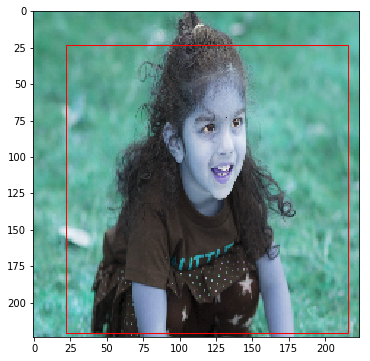

In [0]:
import matplotlib.patches as mpatches
cand = [xmin, ymin, w, h]
cand = np.clip(cand, 1, 223)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)

rect = mpatches.Rectangle(
(cand[0], cand[1]), cand[2], cand[3], fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
plt.grid('off')
plt.show()